In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
# https://en.wikipedia.org/wiki/Tf%E2%80%93idf

[nltk_data] Downloading package punkt to /home/tychi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tychi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tychi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tychi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/tychi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-11-27 14:13:48.475341: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [3]:
# supposedly this speeds up the training time
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
np.random.seed(100)

In [5]:
questions_data = pd.read_csv("processed_questions_lemmatized.csv")

In [6]:
questions_data.head(2)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count,Title_final
0,0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,"['how', 'can', 'i', 'find', 'the', 'full', 'pa...",<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70,"['find', 'full', 'path', 'font', 'display', 'n..."
1,1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,"['get', 'a', 'preview', 'jpeg', 'of', 'a', 'pd...",<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38,"['get', 'preview', 'jpeg', 'pdf', 'window']"


In [7]:
Train_X,\
Test_X,\
Train_Y,\
Test_Y\
= model_selection.train_test_split(questions_data['Title_final'],questions_data['has_positive_answer'],test_size=0.2)

In [8]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [9]:
vocab_size = 5000

In [10]:
Tfidf_vect = TfidfVectorizer(max_features=vocab_size)
Tfidf_vect.fit(questions_data['Title_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X).todense()
Test_X_Tfidf = Tfidf_vect.transform(Test_X).todense()

In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils

In [12]:
Train_X_Tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
num_classes = 2
batch_size = 32
num_epochs = 20

In [14]:
Train_X_Tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Train_Y), y=Train_Y)
class_weights_dict = {}
for i in range(0,2):
    class_weights_dict[i] = class_weights[i]
class_weights_dict

{0: 1.5188486356701598, 1: 0.7453750157260205}

## Build KERAS model

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils
import tensorflow as tf

In [17]:
def build_model(hidden_size):
    input_layer = tf.keras.layers.Input(shape=(vocab_size,), dtype=tf.int64, name='input_layer')
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(input_layer)

    dropout_layer = tf.keras.layers.Dropout(0.03)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout_layer)
    classification_model = tf.keras.Model(inputs=input_layer, outputs=classification)

    classification_model.compile(optimizer='adam',
                                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                     metrics='accuracy')
    return classification_model

2022-11-27 14:14:12.688001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-27 14:14:12.745777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-27 14:14:12.745795: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-27 14:14:12.746426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

Epoch 1/5
15183/15183 [==============================] - 260s 17ms/step - loss: 0.6933 - accuracy: 0.5042 - val_loss: 0.7015 - val_accuracy: 0.3324
Epoch 2/5
15183/15183 [==============================] - 258s 17ms/step - loss: 0.6931 - accuracy: 0.5084 - val_loss: 0.7032 - val_accuracy: 0.3333
Epoch 3/5
15183/15183 [==============================] - 258s 17ms/step - loss: 0.6929 - accuracy: 0.5026 - val_loss: 0.6827 - val_accuracy: 0.6688
Epoch 4/5
15183/15183 [==============================] - 282s 19ms/step - loss: 0.6926 - accuracy: 0.5082 - val_loss: 0.6922 - val_accuracy: 0.6687
Epoch 5/5
15183/15183 [==============================] - 284s 19ms/step - loss: 0.6924 - accuracy: 0.5047 - val_loss: 0.6994 - val_accuracy: 0.3337


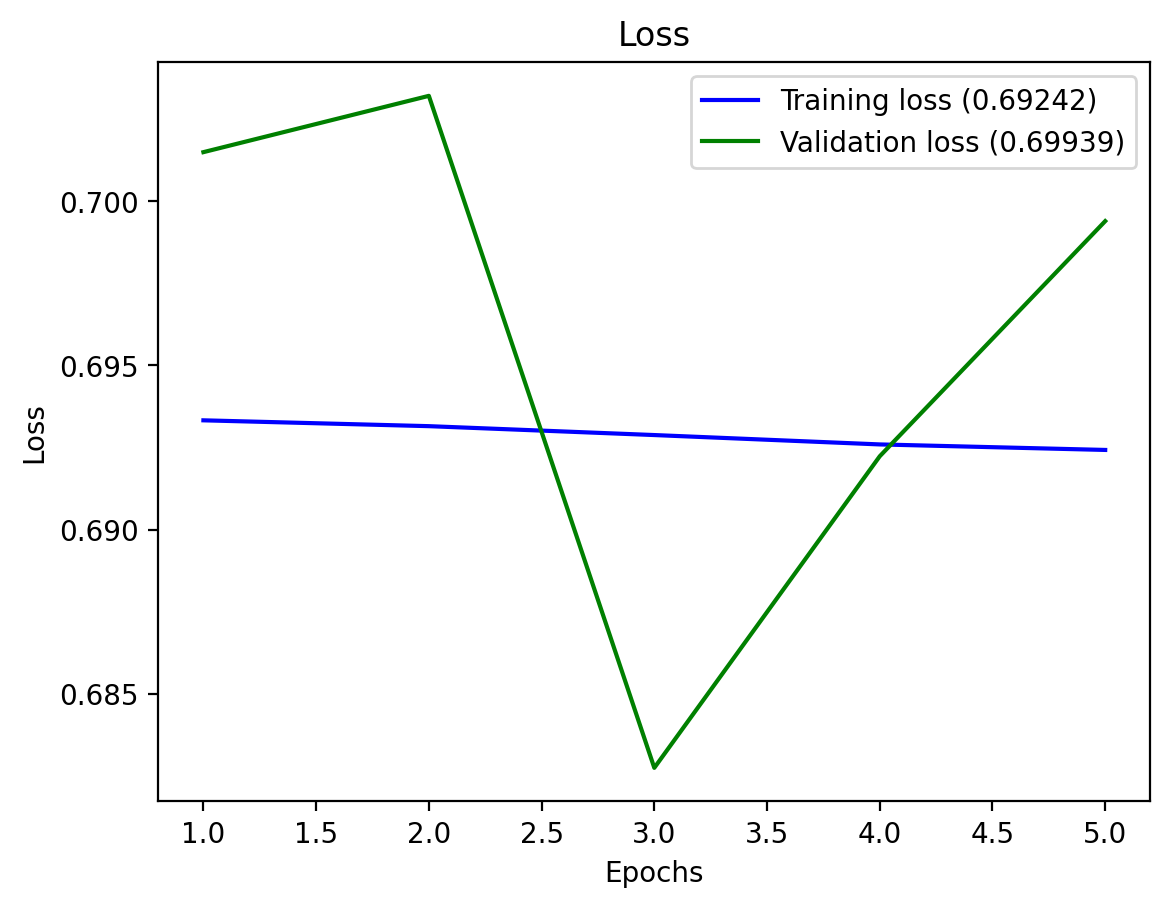

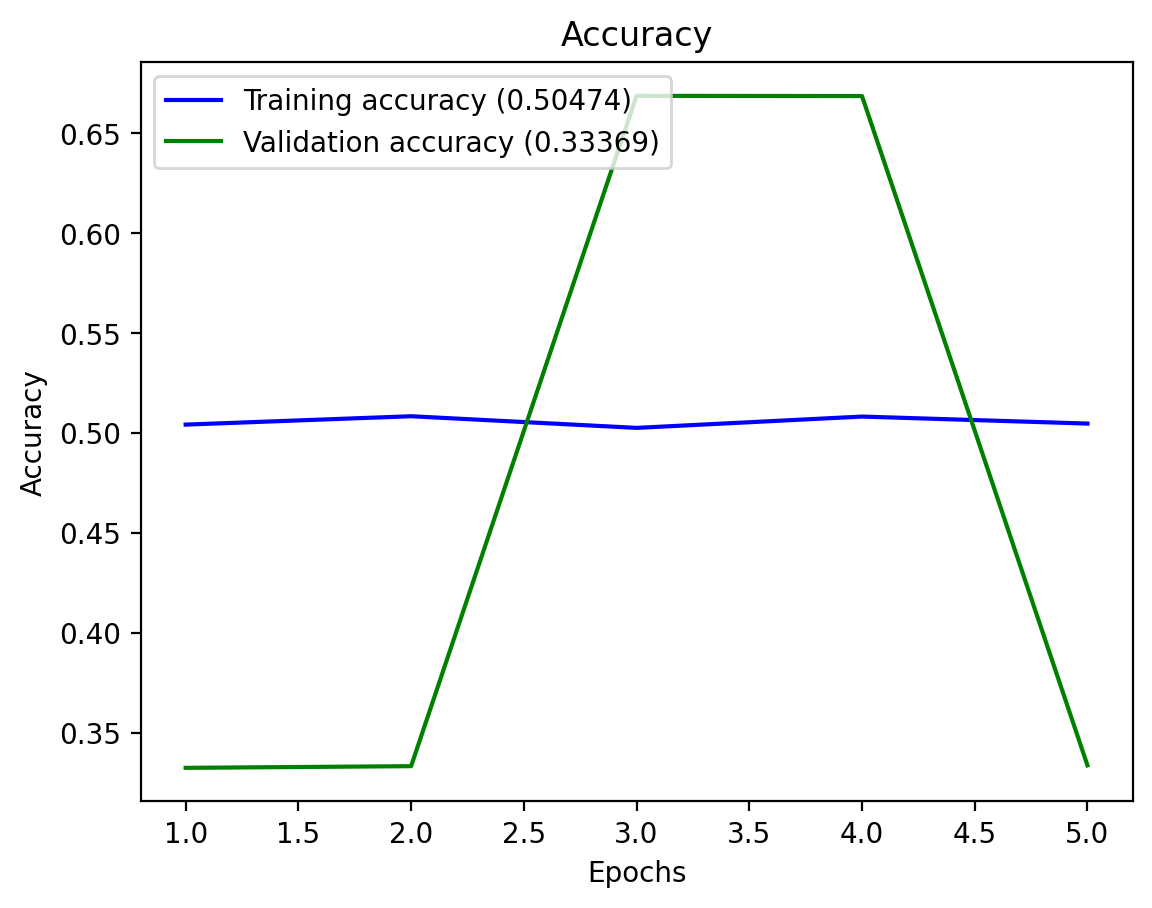

In [18]:
classification_model = build_model(1000)
model_history = classification_model.fit(
    Train_X_Tfidf,
    Train_Y,
    validation_data=(Test_X_Tfidf, Test_Y),
    batch_size=batch_size,
    epochs=5,
    class_weight=class_weights_dict,
    verbose=True
)
plot_history(model_history)

In [19]:
y_pred_raw = classification_model.predict(Test_X_Tfidf)
y_pred = (y_pred_raw > 0.5).astype(int)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(Test_Y, y_pred)

3796/3796 [==============================] - 15s 4ms/step


<AxesSubplot:>

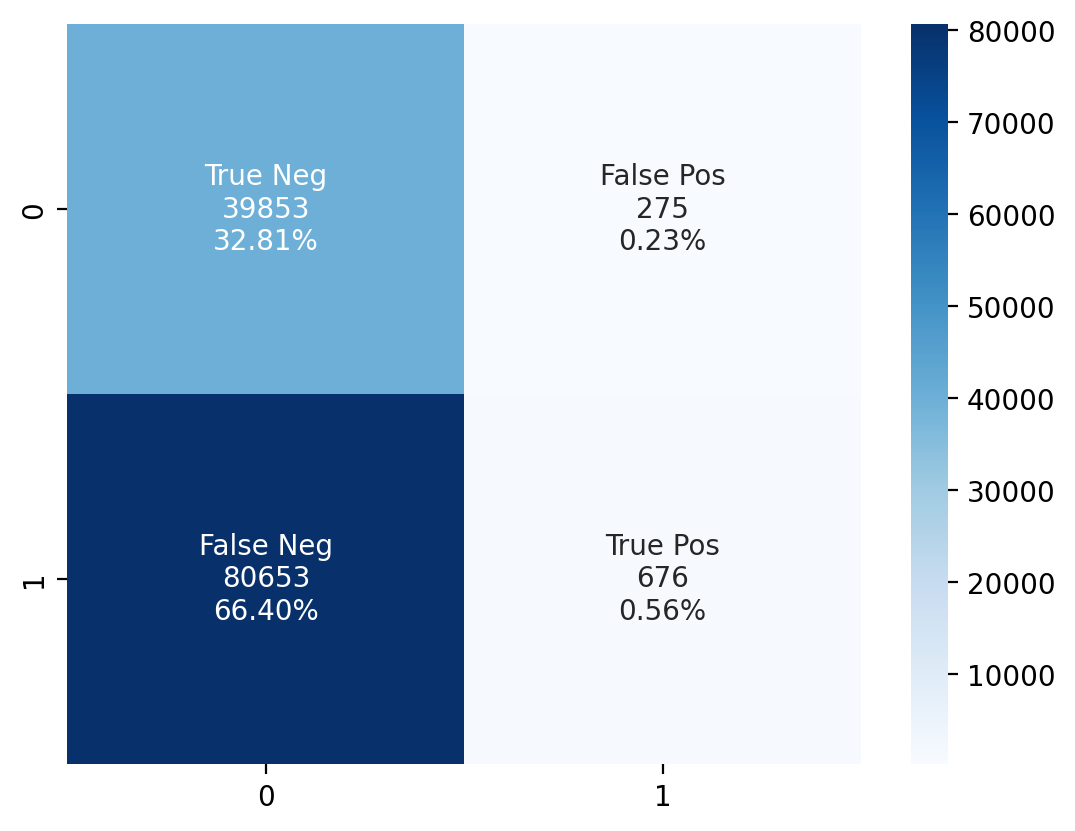

In [20]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

In [21]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Test_Y,  y_pred_raw)
auc = metrics.roc_auc_score(Test_Y, y_pred_raw)

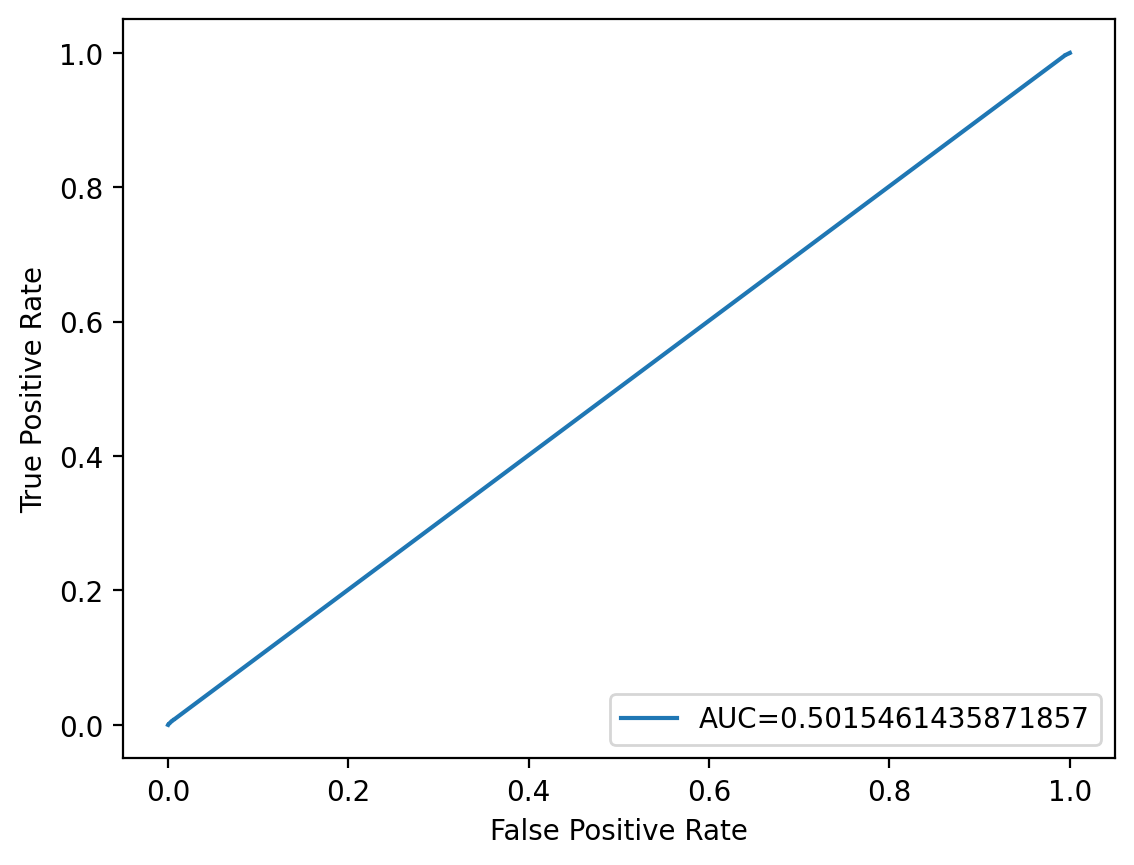

In [24]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(Test_Y, y_pred)
precision = precision_score(Test_Y, y_pred)
recall = recall_score(Test_Y, y_pred)

In [23]:
print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.016431696645600388
precision score is: 0.7108307045215563
recall score is: 0.008311918257939973
